# Predicting CLTV and Customer Repeat with Machine Learning for Shopify 

#### A Data Science Analysis Project by Benjamin N. Bellman 

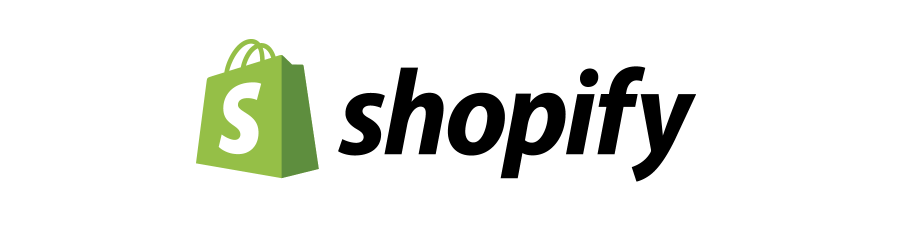

### Project Table of Contents: 
<br>

**I. INTRODUCTION & PRELIMINARY ANALYSIS**
- 1. Project Purpose 
- 2. Loading \& Previewing Data 
- 3. Data Wrangling 
- 4. Preliminary EDA 
 
**II. DATA WRANGLING**  
- 1. Cleaning up data. 
- 2. Creating 3 separate dataframes.
- 3. Creating the final 1 year CLTV Table.

**III. EXPLORATORY DATA ANALYSIS**     
- 1. Loading an Previewing the New Table  
- 2. Exploring relationships of variables on Post First Month Spend </font>  

**IV. PREPROCESSING AND MODELLING** 
- 1. Linear Models
- 2. Classification Models


## Part 2: Exploratory Data Analysis

### Loading our packages and Dataframe. 

In [1]:
## We start by importing the appropriate packages which we will want to use. 
import pandas as pd
import numpy as np
import scipy.stats as stats
from datetime import datetime as dt, timedelta

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.formula.api import ols

%matplotlib inline
pd.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings('ignore')

In [2]:
## We load our cleaned data from the previous notebook and name it customer_cltv then preview its headings.
customer_cltv = pd.read_csv('.\..\cleaned_data_by_month.csv',index_col=0)
customer_cltv.head()

,CustomerID,pfm_spent,fm_nb_orders,fm_nb_items,fm_total_spent,fm_used_coupon,first_order_month,fm_purchased_accessory,first_item_size,accepts_marketing,wealthy_zip,region,first_item_price_range
0,Anonymous13455,1054.80,6,6,253.0,0,7,1,M,0,0,MW,high
1,Anonymous2142,436.15,1,1,48.0,0,5,0,L,0,0,NE,high
2,Anonymous4843,856.75,4,6,292.0,0,10,0,S,1,0,W,high
3,Anonymous11225,614.10,4,4,130.0,0,2,1,No size,1,0,MW,low
4,Anonymous540,1114.75,1,1,50.0,0,1,0,XS,0,0,W,high


In [3]:
## Before we begin, let's take a look at the distribution of our post_first month spend.
print(customer_cltv['pfm_spent'].describe())
print('\n')
no_pfm_count = customer_cltv[customer_cltv['pfm_spent'] ==0]['pfm_spent'].count()
pfm_count = customer_cltv[customer_cltv['pfm_spent'] > 0 ]['pfm_spent'].count()
print('Proportion of customers who ordered post first month: ' + str(round(pfm_count/(no_pfm_count+pfm_count),2)))

count    10595.000000
mean        29.064621
std         82.518923
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max       1430.200000
Name: pfm_spent, dtype: float64


Proportion of customers who ordered post first month: 0.23


It appears that a little more than a quarter of customers made a purchase past the first month. 

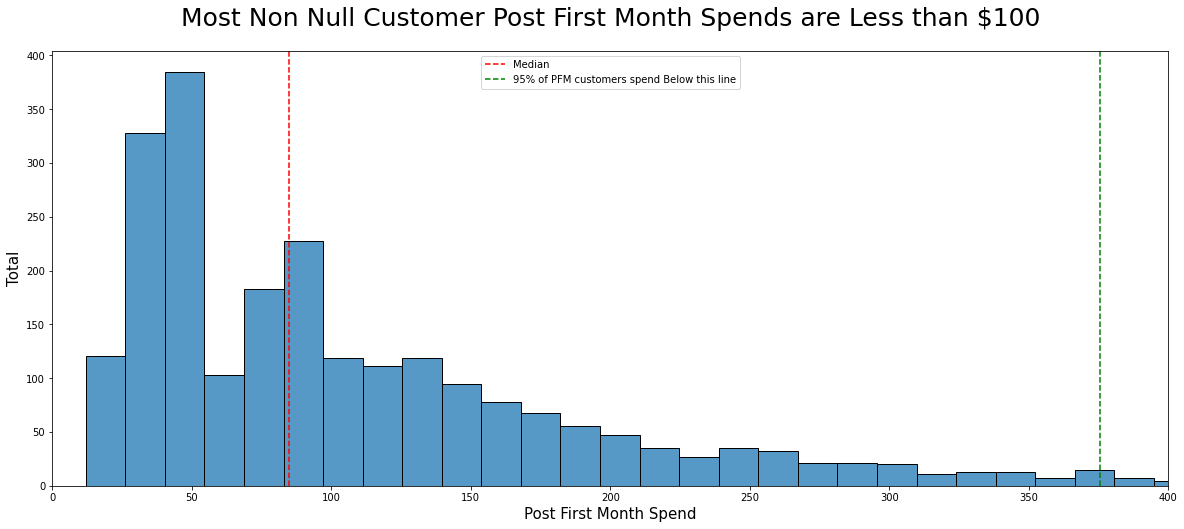

In [4]:
## We visualize the distribution of non-null post first month spend. 
plt.figure(figsize =(20,8))   
sns.histplot(customer_cltv[customer_cltv['pfm_spent'] >0]['pfm_spent'], bins = 100)

# We get the median and the 95th percentile. 
median = customer_cltv[customer_cltv['pfm_spent'] >0]['pfm_spent'].quantile(0.5)
ninetheeth = customer_cltv[customer_cltv['pfm_spent'] >0]['pfm_spent'].quantile(0.95)

# We label the axes and add the median and quantile lines. 
plt.xlim(0,400)
plt.xlabel('Post First Month Spend', fontsize = 15)
plt.ylabel('Total', fontsize = 15)
plt.axvline(x = median, label = 'Median', linestyle ='--', c= 'r' )
plt.axvline(x=ninetheeth, label = '95% of PFM customers spend Below this line', linestyle ='--', c='g')
plt.title('Most Non Null Customer Post First Month Spends are Less than $100', fontsize =25, pad =25)
plt.legend()
plt.show()

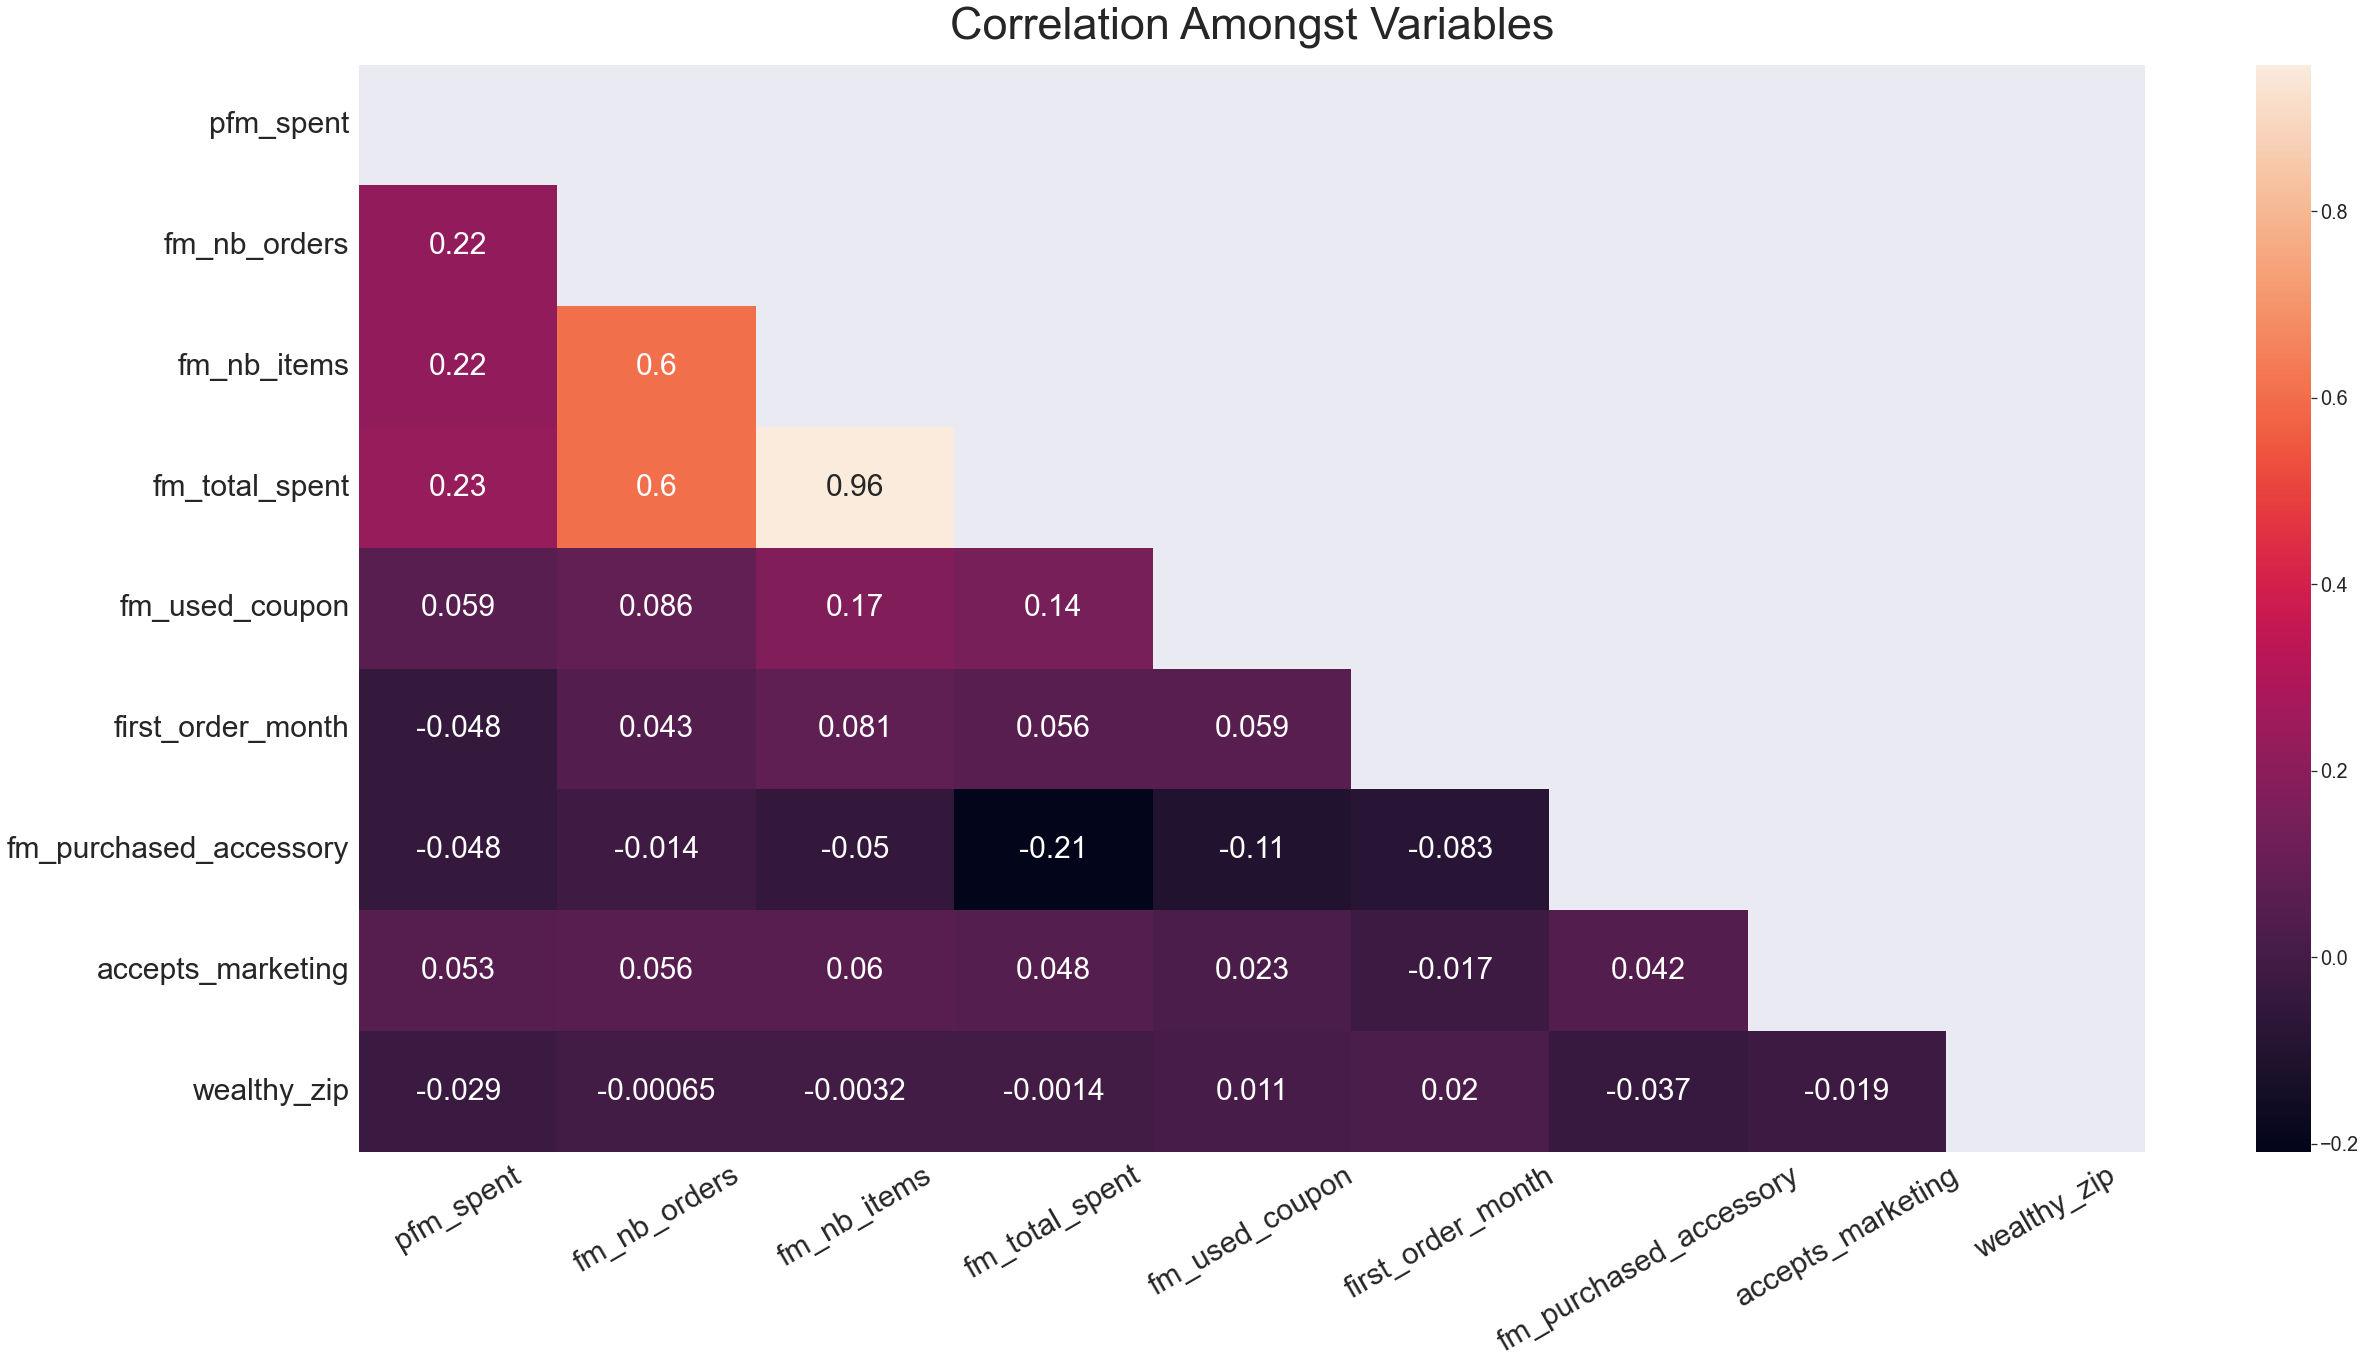

In [5]:
## We create a heatmap to get the Pearson Correlation Coefficient amongst the variables. 
# We pay particular attention to the first column, pfm_spent, our target variable.
plt.figure(figsize =(40,20))
sns.set(font_scale=1.8)
sns.heatmap(customer_cltv.corr(), annot =True,annot_kws={"size":30}, mask = np.triu(customer_cltv.corr()))

# We label the axes.
plt.xticks(fontsize = 30 ,rotation=30) 
plt.yticks(fontsize = 30) 
plt.title('Correlation Amongst Variables', fontsize = 45, pad =25)
plt.show()

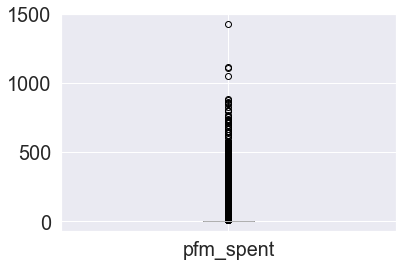

In [6]:
customer_cltv[['fm_nb_orders','pfm_spent']].set_index('fm_nb_orders').boxplot()
plt.show()

<AxesSubplot:xlabel='fm_nb_orders', ylabel='pfm_spent'>

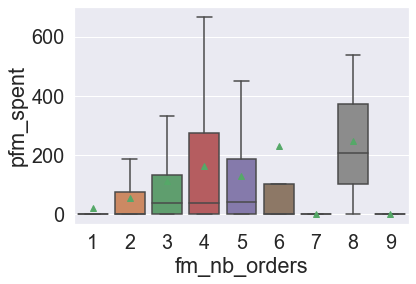

In [7]:
sns.boxplot(x=customer_cltv.fm_nb_orders, y = customer_cltv.pfm_spent, showfliers = False, showmeans = True)

### Exploring Variables:

At quick glance from the heatmap, it appears that two **fm_total_spent , fm_nb_items and fm_nb_orders** correlate have the highest coefficients. We will exploring the relationships amongst a couple of variables to see if they play a role in influencing our post first month spend.

<br> **Variables of Interest**
- fm_nb_orders   
- fm_nb_items
- fm_total_spend
- fm_used_coupon
- fm_accepts_marketing
- region 
- first_item_size 
- fm_purchased_accessory
- first order month
- wealthy zip code

### 1. First Month Spend (FMS) and Post First Month Spend (PFMS) ?

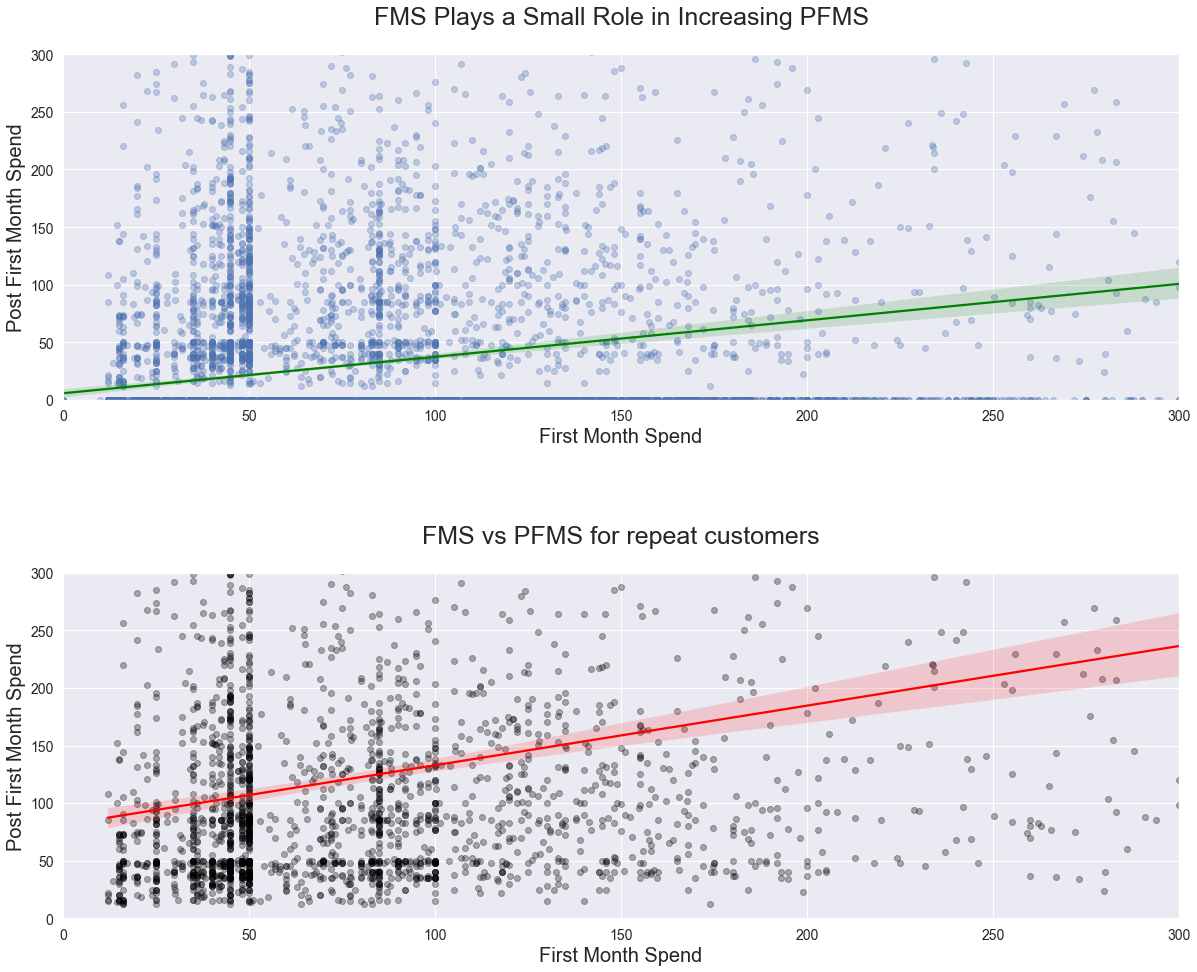

In [8]:
## Let's explore the relationship with 2 scatterplots 
fig, axes = plt.subplots(2,1, figsize =(20,8))
plt.subplots_adjust(left=None, bottom=1, right=None, top=2.5, wspace=None, hspace=0.5)

## The first is for all customers. 
sns.regplot(ax = axes[0], x= 'fm_total_spent',y='pfm_spent', data = customer_cltv,scatter_kws={'alpha':0.3},
            line_kws={"color": "green"})
axes[0].set_title('FMS Plays a Small Role in Increasing PFMS', fontsize = 25, pad=30)
axes[0].set_xlabel('First Month Spend', fontsize =20)
axes[0].set_ylabel('Post First Month Spend', fontsize =20)
axes[0].tick_params(labelsize=14)
axes[0].set_ylim(0,300)
axes[0].set_xlim(0,300)

## The second is for the 27% of customers who made a pfms. 
sns.regplot(ax = axes[1], x= 'fm_total_spent',y='pfm_spent', data = customer_cltv[customer_cltv['pfm_spent'] > 0],
            scatter_kws={"color": "black",'alpha':0.3},line_kws={"color": "red"})
axes[1].set_title('FMS vs PFMS for repeat customers', fontsize = 25, pad=30)
axes[1].set_xlabel('First Month Spend', fontsize =20)
axes[1].set_ylabel('Post First Month Spend', fontsize =20)
axes[1].tick_params(labelsize=14)
axes[1].set_ylim(0,300)
axes[1].set_xlim(0,300)

plt.show()

### 2. Item Size and PFMS

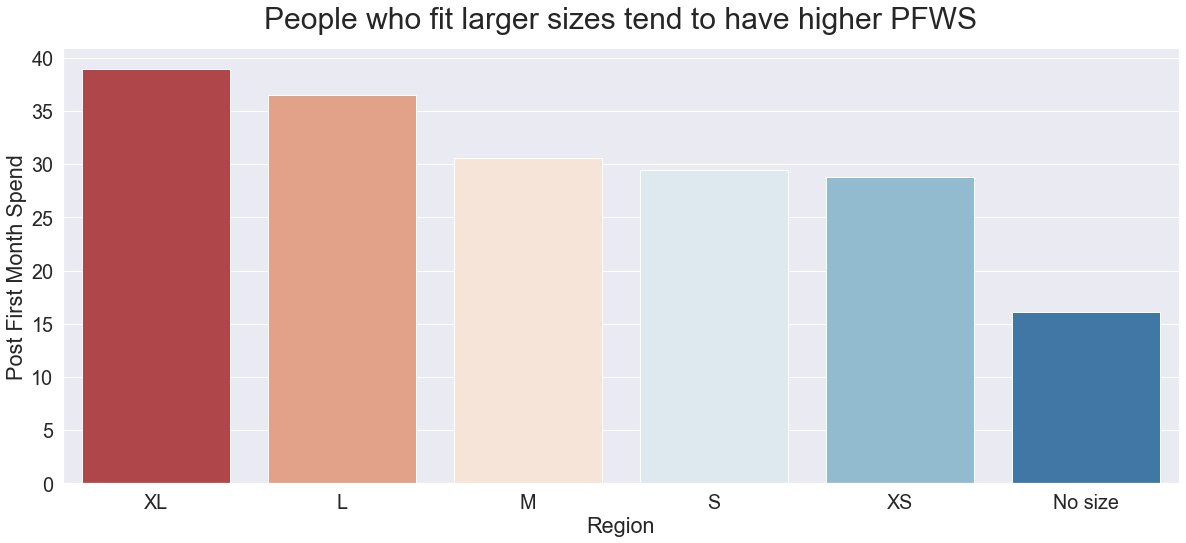

In [39]:
## We aggregate the sizes and sort them from highest mean pfw_spent
sizes = customer_cltv.groupby('first_item_size')['pfm_spent'].mean().reset_index()
sizes.sort_values('pfm_spent',ascending = False, inplace = True)

## We plot them on the bar graph. 
plt.figure(figsize =(20,8))  
sns.barplot(x = sizes.first_item_size, y = sizes.pfm_spent, data = sizes, palette = "RdBu")
plt.xlabel('Region')
plt.ylabel('Post First Month Spend')
plt.title('People who fit larger sizes tend to have higher PFWS', fontsize = 30,pad=20)
plt.show()

## 3. Wealthy Zip Code and PFMS ?

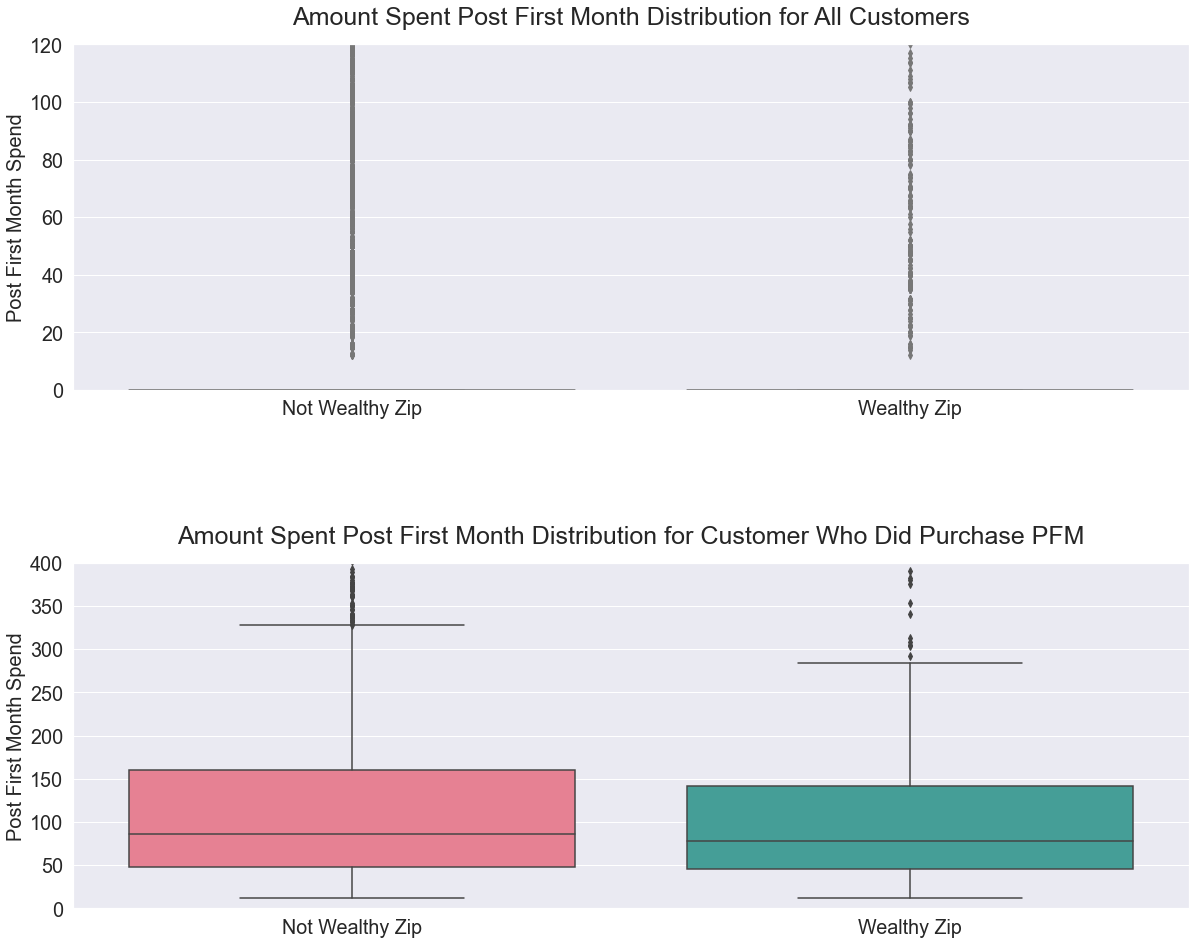

In [10]:
## We visualize the distributions with two boxplots. 
fig, axes = plt.subplots(2,1, figsize =(20,8))
plt.subplots_adjust(left=None, bottom=1, right=None, top=2.5, wspace=None, hspace=0.5)

## The first is for all customers.
sns.boxplot(ax = axes[0],x= 'wealthy_zip',y='pfm_spent', data = customer_cltv, palette = "RdBu")

axes[0].set_title('Amount Spent Post First Month Distribution for All Customers', fontsize = 25, pad=20)
axes[0].set_xlabel('')
axes[0].set_ylabel('Post First Month Spend', fontsize =20)
axes[0].set_xticks([0,1],['Not Wealthy Zip', 'Wealthy Zip'])
axes[0].set_ylim(0, 120)

## The second is for the 27% of customers who made a pfms. 
sns.boxplot(ax = axes[1],x= 'wealthy_zip',y='pfm_spent', 
            data = customer_cltv[customer_cltv['pfm_spent'] > 0], 
            palette = "husl")

axes[1].set_title('Amount Spent Post First Month Distribution for Customer Who Did Purchase PFM', fontsize = 25, pad=20)
axes[1].set_xlabel('')
axes[1].set_ylabel('Post First Month Spend', fontsize =20)
axes[1].set_xticks([0,1],['Not Wealthy Zip', 'Wealthy Zip'])
axes[1].set_ylim(0, 400)

plt.show()

In [11]:
## We compare the different averages for all customers and see how many are in each category. 

print(customer_cltv.groupby('wealthy_zip')['pfm_spent'].mean())
print("\n")
print(customer_cltv.groupby('wealthy_zip')['pfm_spent'].count())
print("\n")
print('Interestingly, it appears that customers in less wealthy zip codes tend to spend more.')

wealthy_zip
0    30.087384
1    23.297801
Name: pfm_spent, dtype: float64


wealthy_zip
0    8999
1    1596
Name: pfm_spent, dtype: int64


Interestingly, it appears that customers in less wealthy zip codes tend to spend more.


## 4. Purchasing an Accessory in the First Month and PFMS ? 

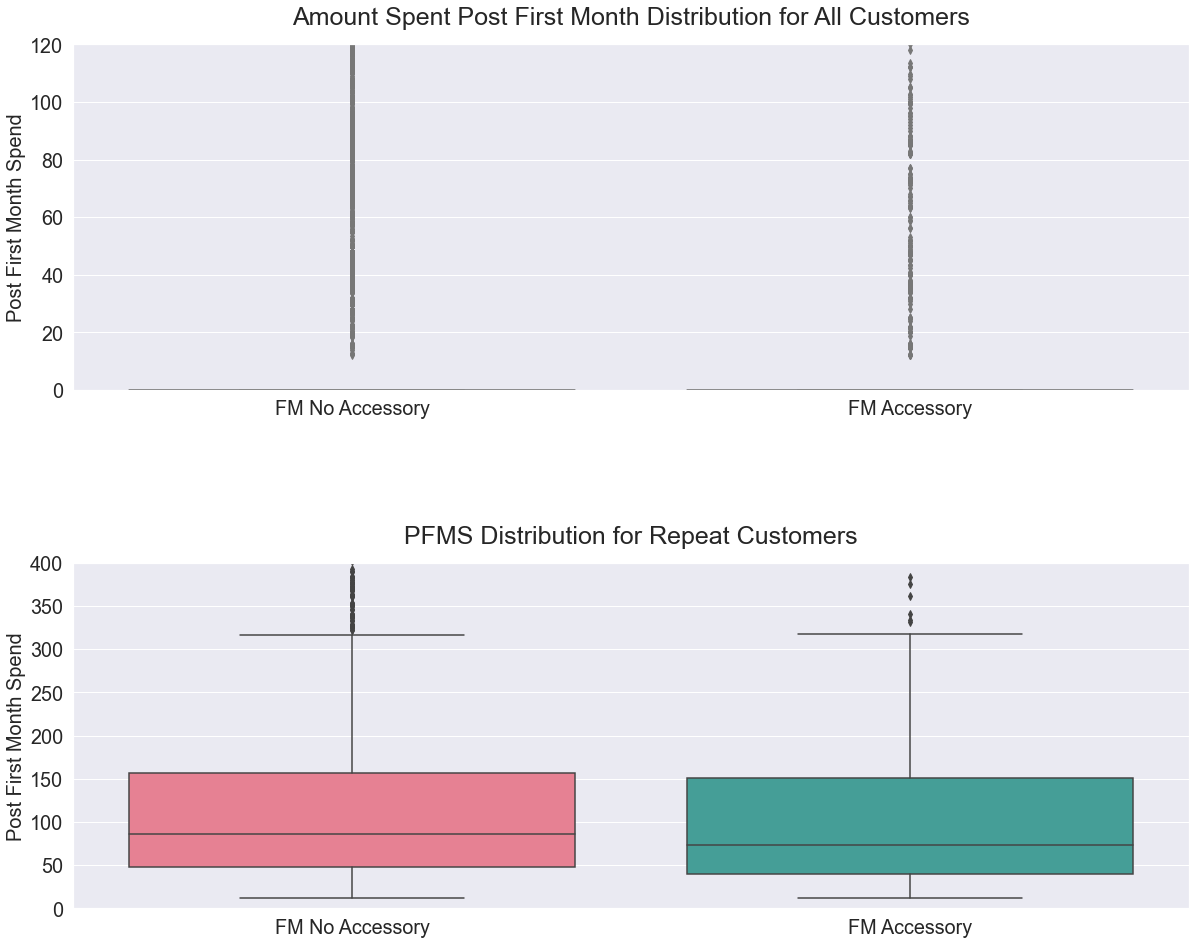

In [12]:
## Let's Visualize the distributions with two boxplots. 
fig, axes = plt.subplots(2,1, figsize =(20,8))
plt.subplots_adjust(left=None, bottom=1, right=None, top=2.5, wspace=None, hspace=0.5)

## The first is for all customers regardless of post first month spend
sns.boxplot(ax = axes[0],x= 'fm_purchased_accessory',y='pfm_spent', data = customer_cltv, palette = "RdBu")

axes[0].set_title('Amount Spent Post First Month Distribution for All Customers', fontsize = 25, pad=20)
axes[0].set_xlabel('')
axes[0].set_ylabel('Post First Month Spend', fontsize =20)
axes[0].set_xticks([0,1],['FM No Accessory', 'FM Accessory'])
axes[0].set_ylim(0, 120)

## The second is for customers whose post first month spend was not 0 (i.e, made purchased past the first month)
sns.boxplot(ax = axes[1],x= 'fm_purchased_accessory',y='pfm_spent',data = customer_cltv[customer_cltv['pfm_spent'] > 0], 
            palette = "husl")

axes[1].set_title('PFMS Distribution for Repeat Customers', fontsize = 25, pad=20)
axes[1].set_xlabel('')
axes[1].set_ylabel('Post First Month Spend', fontsize =20)
axes[1].set_xticks([0,1],['FM No Accessory', 'FM Accessory'])
axes[1].set_ylim(0, 400)

plt.show()

In [13]:
## We compare the different averages for all customers and see how many are in each category. 

print(customer_cltv.groupby('fm_purchased_accessory')['pfm_spent'].mean())
print("\n")
print(customer_cltv.groupby('fm_purchased_accessory')['pfm_spent'].count())
print("\n")
print('It appears customers who purchased an accessory had a smaller PFMS. This indicates that perhaps some customers''\n'
     'come on the platform only to purchase an accessory but not higher priced items.')

fm_purchased_accessory
0    30.992858
1    20.843989
Name: pfm_spent, dtype: float64


fm_purchased_accessory
0    8582
1    2013
Name: pfm_spent, dtype: int64


It appears customers who purchased an accessory had a smaller PFMS. This indicates that perhaps some customers
come on the platform only to purchase an accessory but not higher priced items.


## 5. First Order Month and PFMS ?

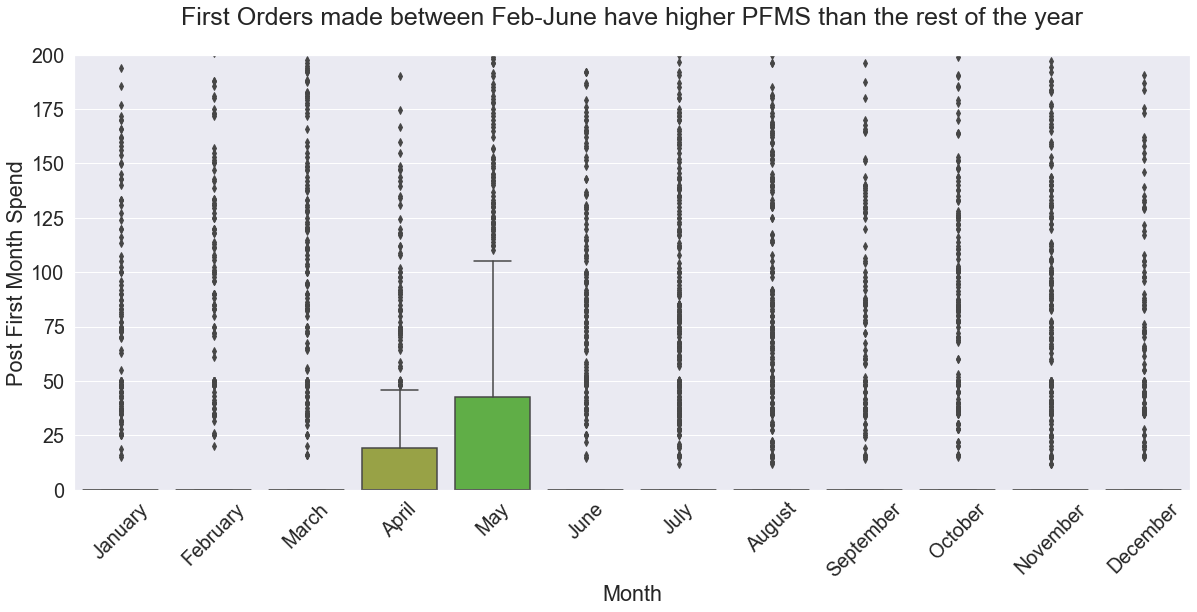

In [14]:
## We use a barplot to compare the PWFS for each month.
plt.figure(figsize =(20,8))
sns.boxplot(x= 'first_order_month',y='pfm_spent', data = customer_cltv)

# We label the axes. 
plt.xlabel('Month')
plt.ylabel('Post First Month Spend')
plt.title('First Orders made between Feb-June have higher PFMS than the rest of the year', fontsize = 25,pad=30 )
plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11],
           ['January', 'February', 'March', 'April', 'May', 'June', 'July',
            'August', 'September', 'October', 'November', 'December'],
           rotation = 45)
plt.ylim(0, 200)
plt.show()

In [15]:
## We compare the mean pfms for each first order month and distribution. 
print(customer_cltv.groupby('first_order_month')['pfm_spent'].mean())
print("\n")
print(customer_cltv.groupby('first_order_month')['pfm_spent'].count())
print("\n")
print('May is the highest month. It looks like pfms is higher for first orders made between February and June' "\n" 
      'relative to the rest of the year.')

first_order_month
1     28.257580
2     37.261621
3     31.141581
4     30.827134
5     41.040410
6     32.833120
7     27.972986
8     28.226554
9     21.645878
10    27.120207
11    20.959458
12    22.396687
Name: pfm_spent, dtype: float64


first_order_month
1      785
2      697
3      879
4      464
5     1001
6      939
7     1363
8     1007
9      752
10     918
11    1126
12     664
Name: pfm_spent, dtype: int64


May is the highest month. It looks like pfms is higher for first orders made between February and June
relative to the rest of the year.


# 6. Region and PFMS ?

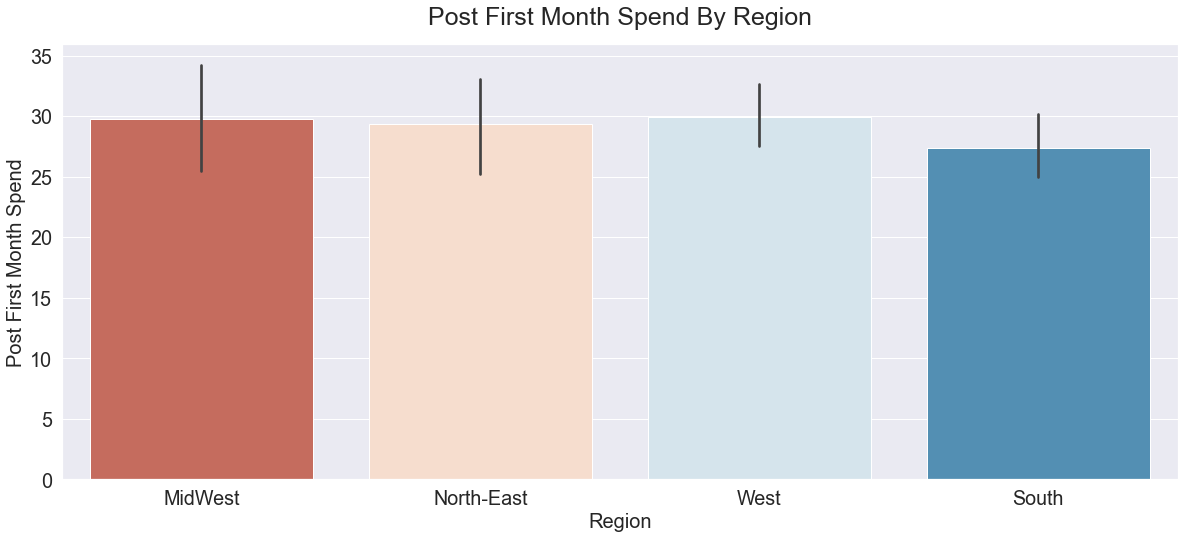

In [16]:
## We use a barplot 
plt.figure(figsize =(20,8))   
sns.barplot(x='region', y='pfm_spent', data = customer_cltv, palette = "RdBu")

# We label the axes
plt.xticks([0,1,2,3],['MidWest','North-East','West','South'])
plt.xlabel('Region', fontsize = 20)
plt.ylabel('Post First Month Spend', fontsize = 20)
plt.title('Post First Month Spend By Region', fontsize = 25,pad=20)
plt.show()

In [17]:
## We look at the distribution of means. 
print(customer_cltv.groupby('region')['pfm_spent'].mean())
print('\n')
print("With a max variation of ~$3.50 across the 4 groups, region doesn't seem to be a good predictor of pfm spend.")

region
MW    29.744941
NE    29.312391
S     27.402690
W     29.963406
Name: pfm_spent, dtype: float64


With a max variation of ~$3.50 across the 4 groups, region doesn't seem to be a good predictor of pfm spend.


# 7. First Month Number of Orders and PFMS ?

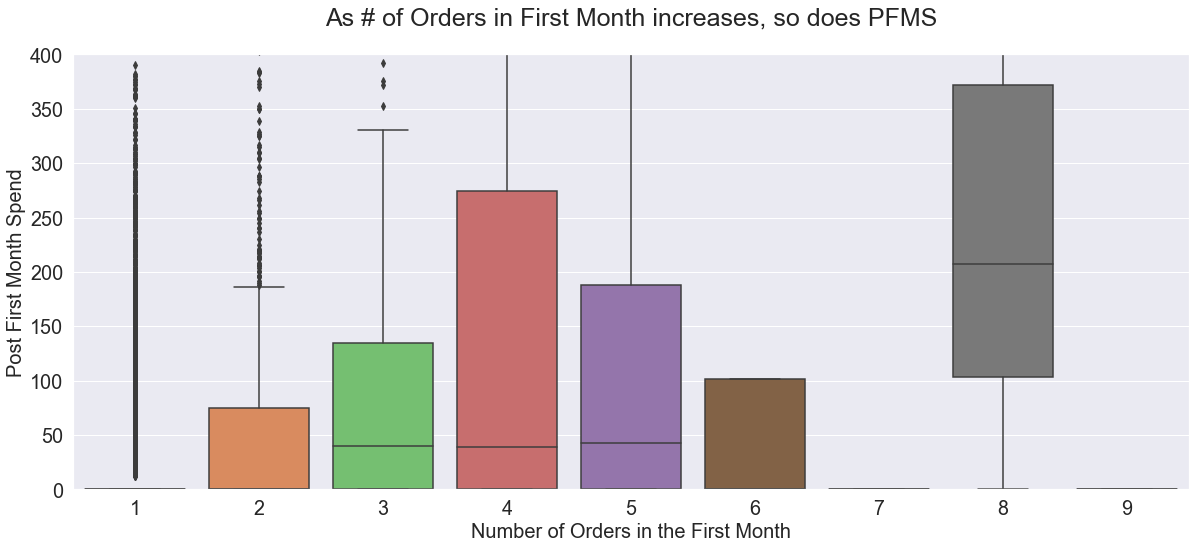

In [18]:
## We plot this with boxplots. 
plt.figure(figsize =(20,8))
sns.boxplot(x= 'fm_nb_orders',y='pfm_spent', data = customer_cltv, palette='muted')

# We assign labels. 
plt.xlabel('Number of Orders in the First Month', fontsize =20)
plt.ylabel('Post First Month Spend', fontsize =20)
plt.title('As # of Orders in First Month increases, so does PFMS', fontsize = 25, pad=30 )
plt.ylim(0, 400)
plt.show()

In [19]:
## We look at the distribution
print("Let's take a look at the distribution:")
print('\n')
print(customer_cltv.fm_nb_orders.value_counts())
print('\n')
print("While it looks like the more orders in the first month, the more the post first month spend increases," "\n"
       "the vast bulk of customers have only made one order, fm_number of items might be a better indicator.")

Let's take a look at the distribution:


1    9182
2    1164
3     167
4      52
5      20
6       5
8       3
9       1
7       1
Name: fm_nb_orders, dtype: int64


While it looks like the more orders in the first month, the more the post first month spend increases,
the vast bulk of customers have only made one order, fm_number of items might be a better indicator.


# 8. First Month Number of Items and PFMS ? 

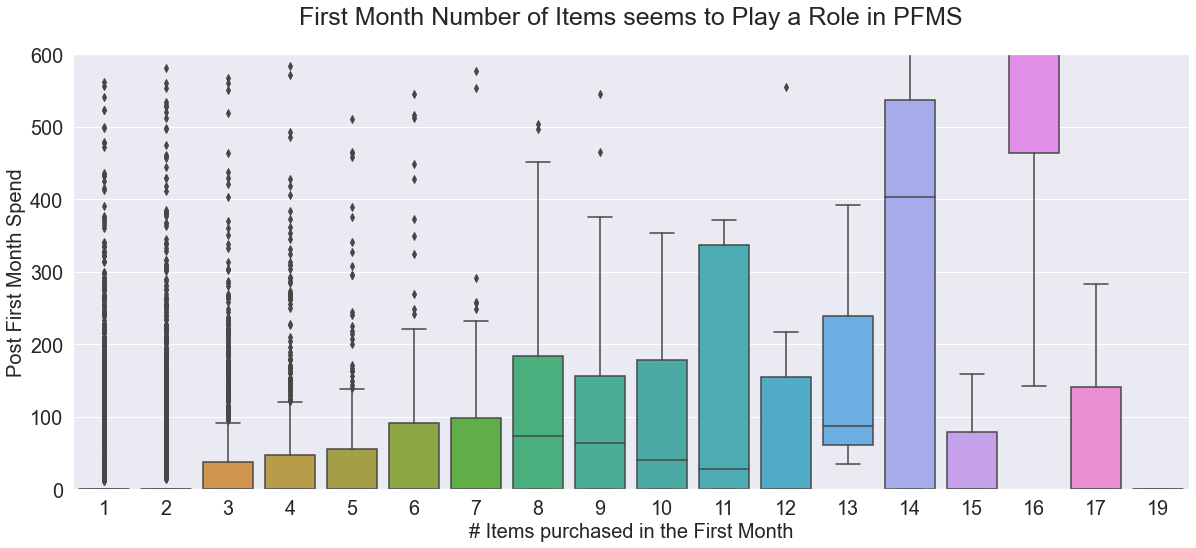

In [20]:
## We use a boxplot. 
plt.figure(figsize =(20,8))   
sns.boxplot(x= 'fm_nb_items',y='pfm_spent', data = customer_cltv)

# We label the axes. 
plt.xlabel('# Items purchased in the First Month', fontsize = 20)
plt.ylabel('Post First Month Spend', fontsize = 20)
plt.title('First Month Number of Items seems to Play a Role in PFMS', fontsize = 25, pad =30)
plt.ylim(0, 600)
plt.show()

In [21]:
## We look at the distribution. 
print("Let's take a look at the distribution:")
print(customer_cltv.fm_nb_items.value_counts())
print('\n')
print("This looks to be a better indicator than the first month number of orders and was allready correlated." "\n"
      "Let's perform ANOVA.")

Let's take a look at the distribution:
1     5727
2     2590
3     1111
4      619
5      236
6      134
7       68
8       37
9       23
12      14
10      10
11       9
14       5
15       3
13       3
17       3
16       2
19       1
Name: fm_nb_items, dtype: int64


This looks to be a better indicator than the first month number of orders and was allready correlated.
Let's perform ANOVA.


In [22]:
# stats f_oneway functions takes the groups as input and returns ANOVA F and p value
fvalue, pvalue = stats.f_oneway(customer_cltv[customer_cltv['fm_nb_items'] == 1]['pfm_spent'],
                                customer_cltv[customer_cltv['fm_nb_items'] == 2]['pfm_spent'], 
                                customer_cltv[customer_cltv['fm_nb_items'] == 3]['pfm_spent'], 
                                customer_cltv[customer_cltv['fm_nb_items'] == 4]['pfm_spent'])
print(fvalue, pvalue)


model = ols('pfm_spent ~ C(fm_nb_items)', data=customer_cltv).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

## https://www.reneshbedre.com/blog/anova.html

50.73114483710378 1.5568781243414222e-32


,sum_sq,df,F,PR(>F)
C(fm_nb_items),4.573510e+06,17.0,42.115462,2.353592e-136
Residual,6.756498e+07,10577.0,NaN,NaN


# 9. Coupon Use in the First Month and PFMS

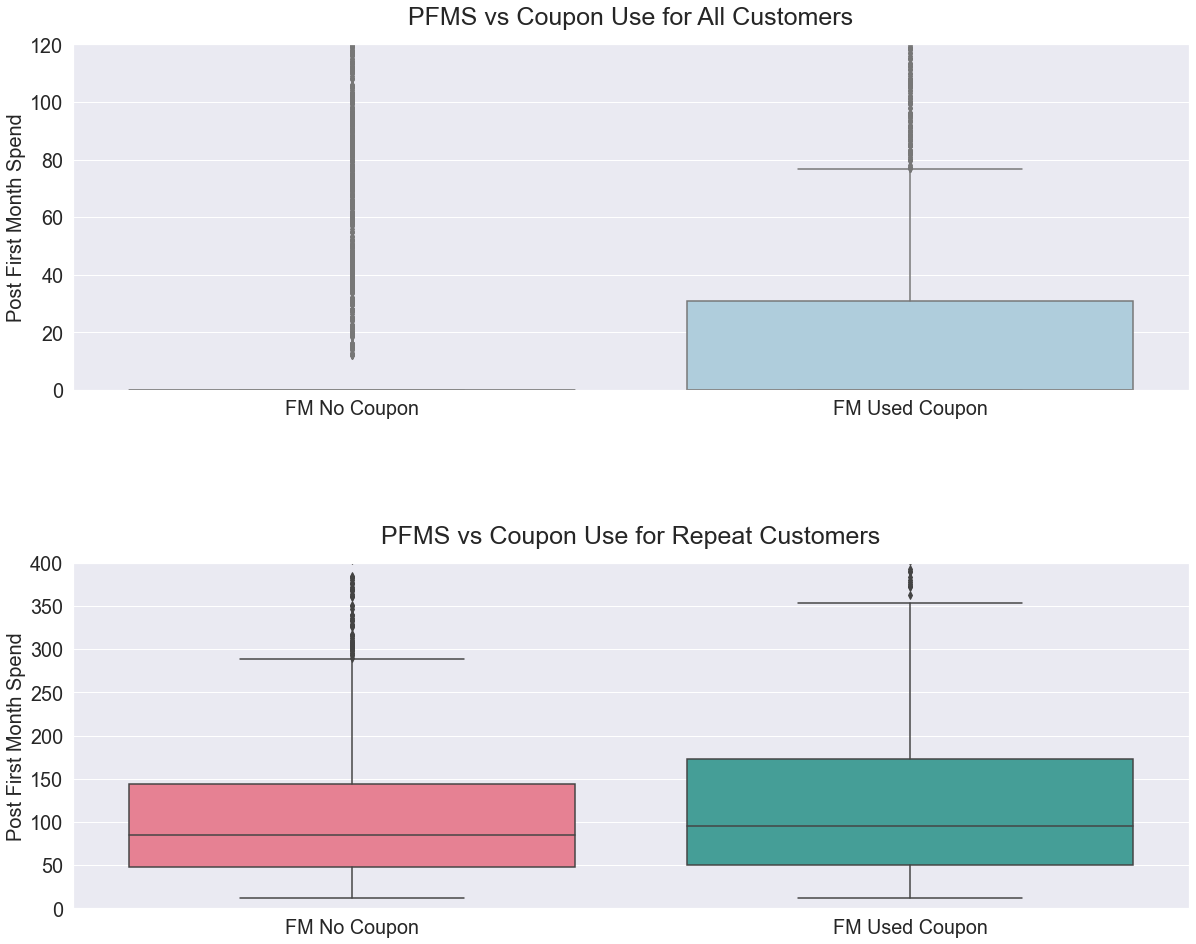

In [23]:
## Let's Visualize the distributions with two boxplots. 
fig, axes = plt.subplots(2,1, figsize =(20,8))
plt.subplots_adjust(left=None, bottom=1, right=None, top=2.5, wspace=None, hspace=0.5)

## The first is for all customers.
sns.boxplot(ax = axes[0],x= 'fm_used_coupon',y='pfm_spent', data = customer_cltv, palette = "RdBu")

axes[0].set_title('PFMS vs Coupon Use for All Customers', fontsize = 25, pad=20)
axes[0].set_xlabel('')
axes[0].set_ylabel('Post First Month Spend', fontsize =20)
axes[0].set_xticks([0,1],['FM No Coupon', 'FM Used Coupon'])
axes[0].set_ylim(0, 120)

## The second is for the 27% of customers who made a pfms. 
sns.boxplot(ax = axes[1],x= 'fm_used_coupon',y='pfm_spent', data = customer_cltv[customer_cltv['pfm_spent'] > 0],
            palette = "husl")

axes[1].set_title('PFMS vs Coupon Use for Repeat Customers', fontsize = 25, pad=20)
axes[1].set_xlabel('')
axes[1].set_ylabel('Post First Month Spend', fontsize =20)
axes[1].set_xticks([0,1],['FM No Coupon', 'FM Used Coupon'])
axes[1].set_ylim(0, 400)

plt.show()

In [24]:
## Let's look at the means and the differences
customer_cltv.groupby('fm_used_coupon')['pfm_spent'].describe()

,count,mean,std,min,25%,50%,75%,max
fm_used_coupon,,,,,,,,
0,7653.0,26.053439,77.490082,0.0,0.0,0.0,0.00,1114.75
1,2942.0,36.897583,93.916508,0.0,0.0,0.0,30.75,1430.20


In this dataset, it looks like the vast majority did not repurchase

In [25]:
## Let's get the difference in means between both groups.
diff_means = (customer_cltv[customer_cltv['fm_used_coupon'] == 1]['pfm_spent'].mean() -
             customer_cltv[customer_cltv['fm_used_coupon'] == 0]['pfm_spent'].mean())
print('The difference in means between both groups: ~$' + str(round(diff_means,2)))

The difference in means between both groups: ~$10.84


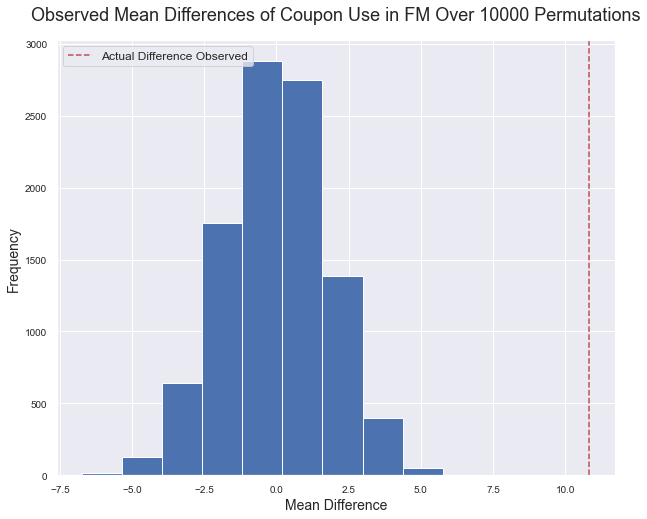

In [26]:
## We will create permutations to look at the observed mean differences
difference = []
for i in range(10000):
    permutation = np.random.permutation(customer_cltv['pfm_spent'])
    difference.append(np.mean(permutation[customer_cltv['fm_used_coupon'] == 0]) - 
                      np.mean(permutation[customer_cltv['fm_used_coupon'] == 1]))

## We plot the observed mean differences and compare to the one we observed. 
plt.figure(figsize =(10,8))    
plt.hist(difference, bins = 10)
plt.axvline(diff_means,linestyle='--', c='r', label='Actual Difference Observed')
plt.title('Observed Mean Differences of Coupon Use in FM Over 10000 Permutations', fontsize = 18, pad=20)
plt.xlabel('Mean Difference', fontsize =14)
plt.ylabel('Frequency', fontsize =14)
plt.xticks(fontsize =10)
plt.yticks(fontsize =10)
plt.legend(loc=2, fontsize =12)
plt.show()

In [27]:
## Let's run difference in means test.
stats.ttest_ind(np.array(customer_cltv[customer_cltv['fm_used_coupon'] == 1]['pfm_spent']), 
                np.array(customer_cltv[customer_cltv['fm_used_coupon'] == 0]['pfm_spent']))

Ttest_indResult(statistic=6.068222223959299, pvalue=1.3375907043585383e-09)

# 10. Opting into Marketing Emails and PFMS?

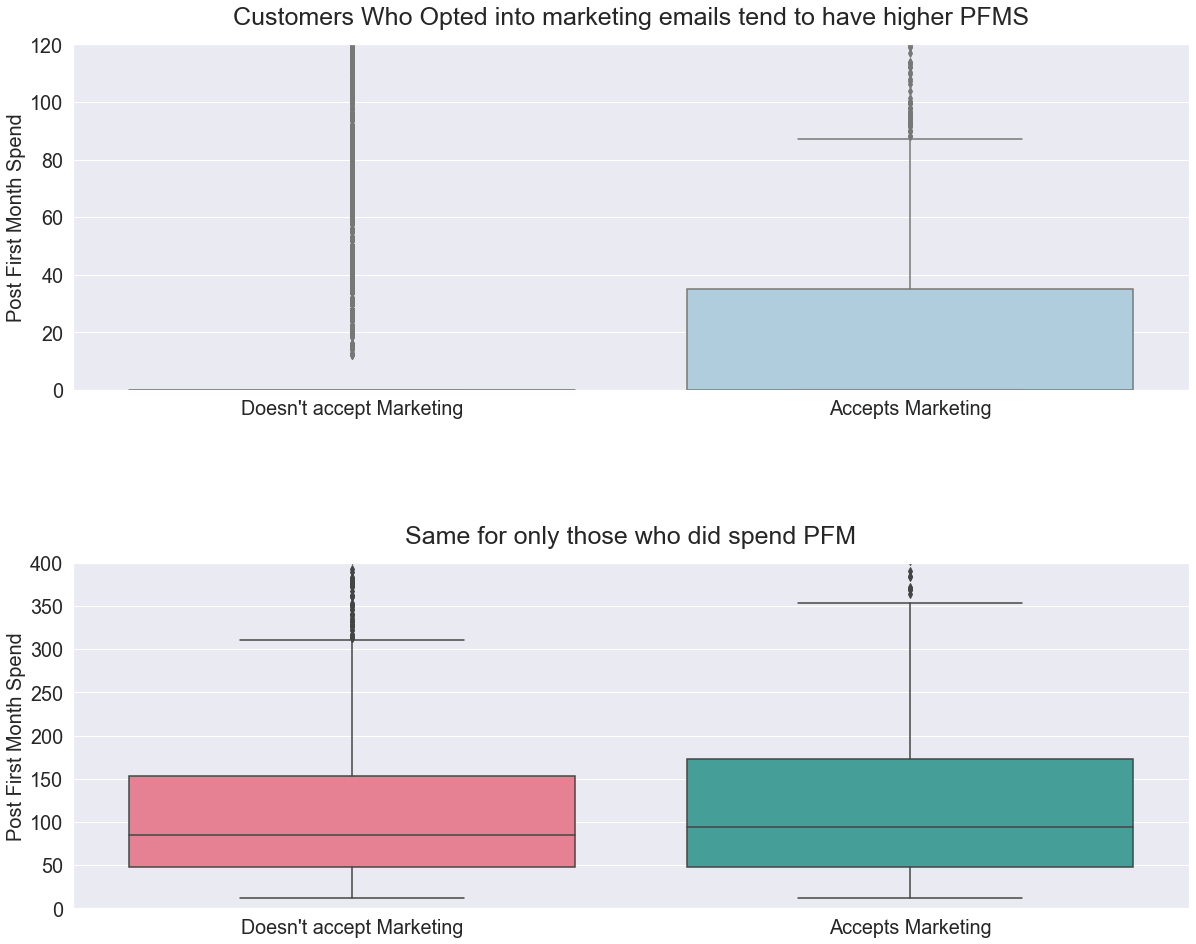

In [28]:
## Let's Visualize the distributions with two boxplots. 
fig, axes = plt.subplots(2,1, figsize =(20,8))
plt.subplots_adjust(left=None, bottom=1, right=None, top=2.5, wspace=None, hspace=0.5)

## The first is for all customers.
sns.boxplot(ax = axes[0],x= 'accepts_marketing',y='pfm_spent', data = customer_cltv, palette = "RdBu")

axes[0].set_title('Customers Who Opted into marketing emails tend to have higher PFMS', fontsize = 25, pad=20)
axes[0].set_xlabel('')
axes[0].set_ylabel('Post First Month Spend', fontsize =20)
axes[0].set_xticks([0,1],["Doesn't accept Marketing", 'Accepts Marketing'])
axes[0].set_ylim(0, 120)


## The second is for the 27% of customers who made a pfms. 
sns.boxplot(ax = axes[1],x= 'accepts_marketing',y='pfm_spent', data = customer_cltv[customer_cltv['pfm_spent'] > 0],
            palette = "husl")

axes[1].set_title('Same for only those who did spend PFM', fontsize = 25, pad=20)
axes[1].set_xlabel('')
axes[1].set_ylabel('Post First Month Spend', fontsize =20)
axes[1].set_xticks([0,1],["Doesn't accept Marketing", 'Accepts Marketing'])
axes[1].set_ylim(0, 400)

plt.show()

In [29]:
## Let's look at the means and the differences
customer_cltv.groupby('accepts_marketing')['pfm_spent'].describe()

,count,mean,std,min,25%,50%,75%,max
accepts_marketing,,,,,,,,
0,9029.0,27.254647,78.720160,0.0,0.0,0.0,0.0,1430.20
1,1566.0,39.500287,101.090187,0.0,0.0,0.0,35.0,883.75


In [30]:
## Let's get the difference in means between both groups.
diff_means = (customer_cltv[customer_cltv['accepts_marketing'] == 1]['pfm_spent'].mean() -
             customer_cltv[customer_cltv['accepts_marketing'] == 0]['pfm_spent'].mean())
print('The difference in means between both groups: ~$' + str(round(diff_means,2)))

The difference in means between both groups: ~$12.25


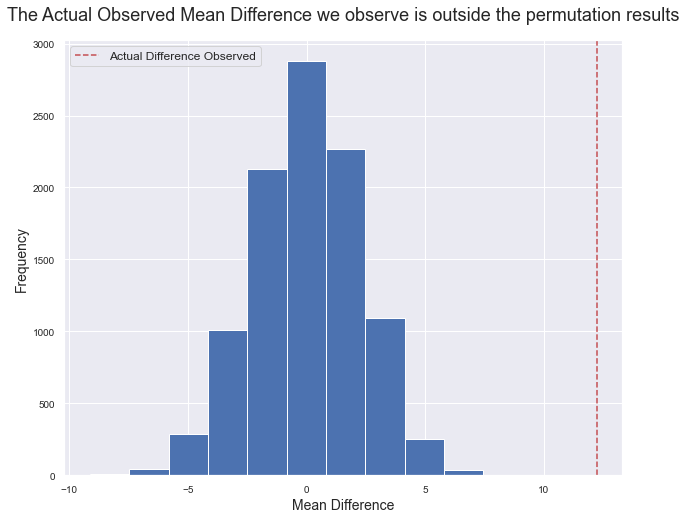

In [31]:
## We will create permutations to look at the observed mean differences
difference = []
for i in range(10000):
    permutation = np.random.permutation(customer_cltv['pfm_spent'])
    difference.append(np.mean(permutation[customer_cltv['accepts_marketing'] == 0]) - 
                      np.mean(permutation[customer_cltv['accepts_marketing'] ==1]))

plt.figure(figsize =(10,8))    
plt.hist(difference, bins = 10)
plt.axvline(diff_means,linestyle='--', c='r', label='Actual Difference Observed')
plt.legend(loc=2, fontsize =12)
plt.xlabel('Mean Difference', fontsize =14)
plt.ylabel('Frequency', fontsize =14)
plt.title('The Actual Observed Mean Difference we observe is outside the permutation results', fontsize = 18, pad=20)
plt.xticks(fontsize =10)
plt.yticks(fontsize =10)
plt.show()

In [32]:
## Let's run difference in means test.
stats.ttest_ind(np.array(customer_cltv[customer_cltv['accepts_marketing'] == 1]['pfm_spent']), 
                np.array(customer_cltv[customer_cltv['accepts_marketing'] == 0]['pfm_spent']))

Ttest_indResult(statistic=5.428450687277761, pvalue=5.809971864437766e-08)

In [33]:
## Now let's do the same thing but for those who did spend PFM.
diff_means = (customer_cltv[(customer_cltv['accepts_marketing'] == 1) & 
                            (customer_cltv['pfm_spent'] > 0)]['pfm_spent'].mean() -
             customer_cltv[(customer_cltv['accepts_marketing'] == 0) & 
                           (customer_cltv['pfm_spent'] > 0)]['pfm_spent'].mean())
print('The difference in means between both groups: ~$' + str(round(diff_means,2)))

The difference in means between both groups: ~$18.92


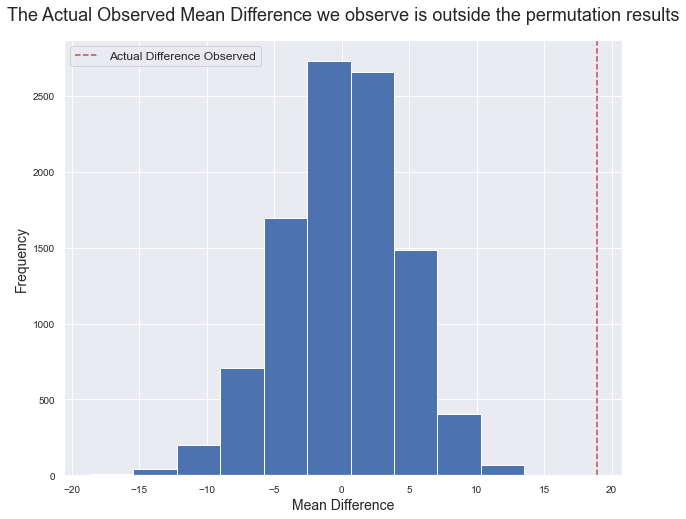

In [34]:
## We will create permutations to look at the observed mean differences
difference = []
for i in range(10000):
    permutation = np.random.permutation(customer_cltv['pfm_spent'])
    difference.append(np.mean(permutation[(customer_cltv['accepts_marketing'] == 0) & (customer_cltv['pfm_spent'] > 0)]) - 
                      np.mean(permutation[(customer_cltv['accepts_marketing'] == 1) & (customer_cltv['pfm_spent'] > 0)]))

plt.figure(figsize =(10,8))    
plt.hist(difference, bins = 10)
plt.axvline(diff_means,linestyle='--', c='r', label='Actual Difference Observed')
plt.title('The Actual Observed Mean Difference we observe is outside the permutation results', fontsize = 18, pad=20)
plt.xlabel('Mean Difference', fontsize =14)
plt.ylabel('Frequency', fontsize =14)
plt.xticks(fontsize =10)
plt.yticks(fontsize =10)
plt.legend(loc=2, fontsize =12)
plt.show()

In [35]:
## Let's run difference in means test.
stats.ttest_ind(np.array(customer_cltv[(customer_cltv['accepts_marketing'] == 1) & 
                                       (customer_cltv['pfm_spent'] > 0)]['pfm_spent']), 
                np.array(customer_cltv[(customer_cltv['accepts_marketing'] == 0) & 
                                       (customer_cltv['pfm_spent'] > 0)]['pfm_spent']))

Ttest_indResult(statistic=2.7072650596360126, pvalue=0.0068320068815016415)